In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
%matplotlib inline
from matplotlib.pylab import rcParams

C:\Users\KAMAU\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd
import numpy as np
import random
import os
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LayerNormalization, Conv1D, MaxPooling1D, Flatten, MultiHeadAttention, Input, GlobalAveragePooling1D, Concatenate, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [3]:
rcParams['figure.figsize'] = 10, 6
rcParams['axes.titlesize'] = 'large'
rcParams['axes.titleweight'] = 'bold'
rcParams["legend.loc"] = 'upper left'

In [4]:
#Reading the Excel file using pandas
df1 = pd.read_excel('NIJ2013_JAN01_DEC31.xlsx')
df2 = pd.read_excel('NIJ2014_JAN01_DEC31.xlsx')
df3 = pd.read_excel('NIJ2015_JAN01_DEC31.xlsx')
df4 = pd.read_excel('NIJ2016_JAN01_JUL31.xlsx')
df5 = pd.read_excel('NIJ2016_AUG01_AUG31.xlsx')
df6 = pd.read_excel('NIJ2016_SEP01_SEP30.xlsx')
df7 = pd.read_excel('NIJ2016_OCT01_OCT31.xlsx')
df8 = pd.read_excel('NIJ2016_NOV01_NOV30.xlsx')
df9 = pd.read_excel('NIJ2016_DEC01_DEC31.xlsx')

In [5]:
#Concatenating databases vertically
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9], ignore_index=True)

In [6]:
#Using isnull to get total number of null values in @ column
df.isnull().sum()

CATEGORY               0
CALL GROUPS            0
final_case_type        0
CASE DESC              0
occ_date               0
x_coordinate           0
y_coordinate           0
census_tract       44406
dtype: int64

In [7]:
# Removing duplicated rows
df.drop_duplicates(inplace = True)

In [8]:
# Removing some specific columns
columns_to_remove = ['final_case_type', 'CASE DESC']

df.drop(columns=columns_to_remove, inplace = True)

# Daily Street Crimes

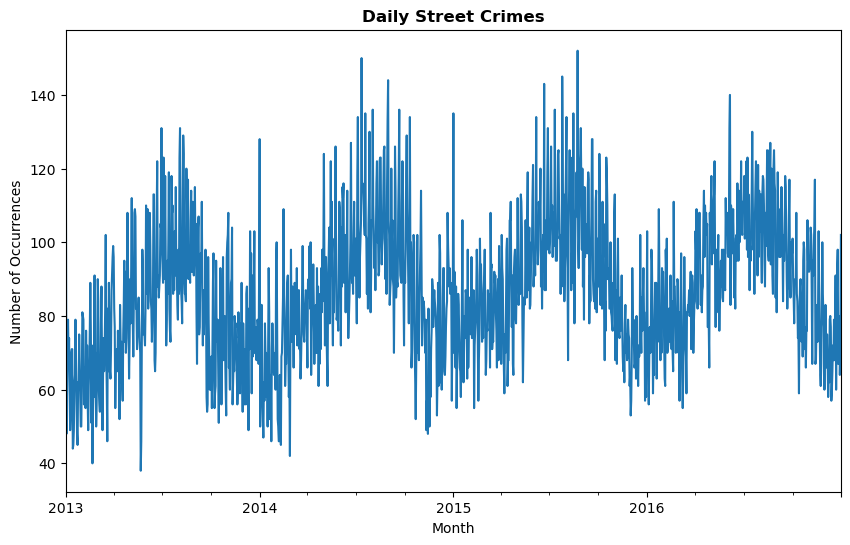

In [9]:
# Assuming 'occ_date' is already in datetime format
df['occ_date'] = pd.to_datetime(df['occ_date'])

# Classify CATEGORY per month
street_crimes_daily = df.loc[df['CATEGORY']== 'STREET CRIMES'].groupby(['occ_date']).size()

# Create a line graph
street_crimes_daily.plot(kind='line')

# Customize the plot
plt.title('Daily Street Crimes')
plt.xlabel('Month')
plt.ylabel('Number of Occurrences')

# Show the plot
plt.show()

# Monthly Street Crimes

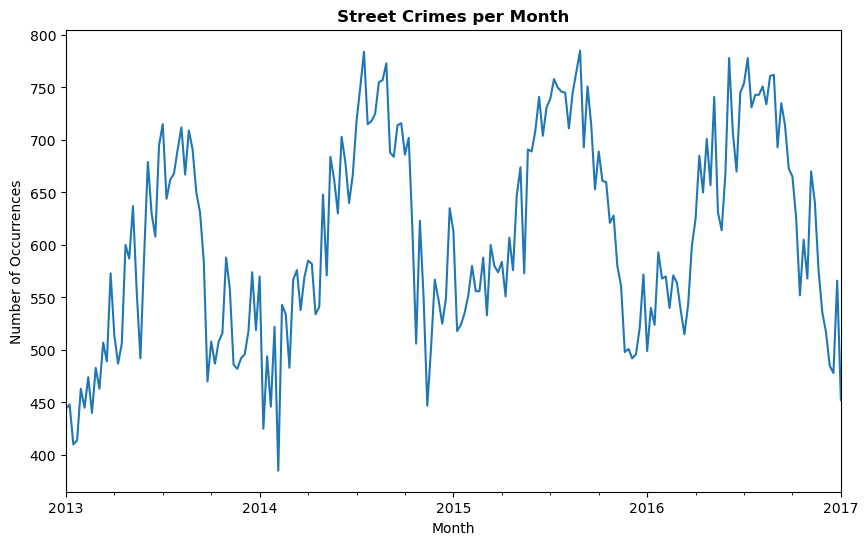

In [10]:
# Assuming 'occ_date' is already in datetime format
df['occ_date'] = pd.to_datetime(df['occ_date'])

# Classify CATEGORY per month and calculate monthly averages
street_crimes = df.loc[df['CATEGORY'] == 'STREET CRIMES'].resample('W', on='occ_date').size()

# Create a line graph
street_crimes.plot(kind='line')

# Customize the plot
plt.title('Street Crimes per Month')
plt.xlabel('Month')
plt.ylabel('Number of Occurrences')

# Show the plot
plt.show()

# Splitting Dataset

In [11]:
split_validation = len(street_crimes) - 39
split_test = len(street_crimes) - 13
ts, ts_val, ts_test = (
    street_crimes[0:split_validation],
    street_crimes[split_validation:split_test],
    street_crimes[split_test:],
)
print("Training %d, Validation %d, Test %d" % (len(ts), len(ts_val), len(ts_test)))
print(type(ts))

Training 170, Validation 26, Test 13
<class 'pandas.core.series.Series'>


# Checking Stationarity

In [12]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=13, center=False).mean()
    rolstd = timeseries.rolling(window=13, center=False).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

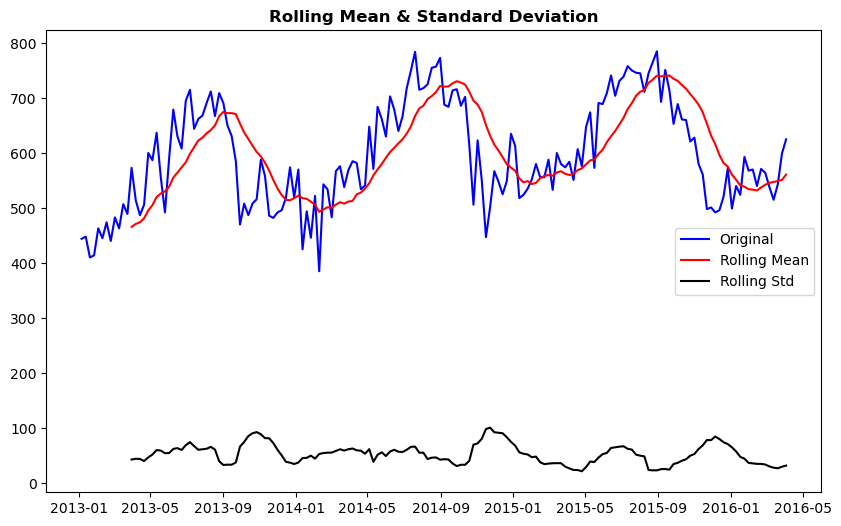

Results of Dickey-Fuller Test:
Test Statistic                  -2.688136
p-value                          0.076114
#Lags Used                       2.000000
Number of Observations Used    167.000000
Critical Value (1%)             -3.470126
Critical Value (5%)             -2.879008
Critical Value (10%)            -2.576083
dtype: float64
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [13]:
test_stationarity(ts)

# Making a Time Series Stationary

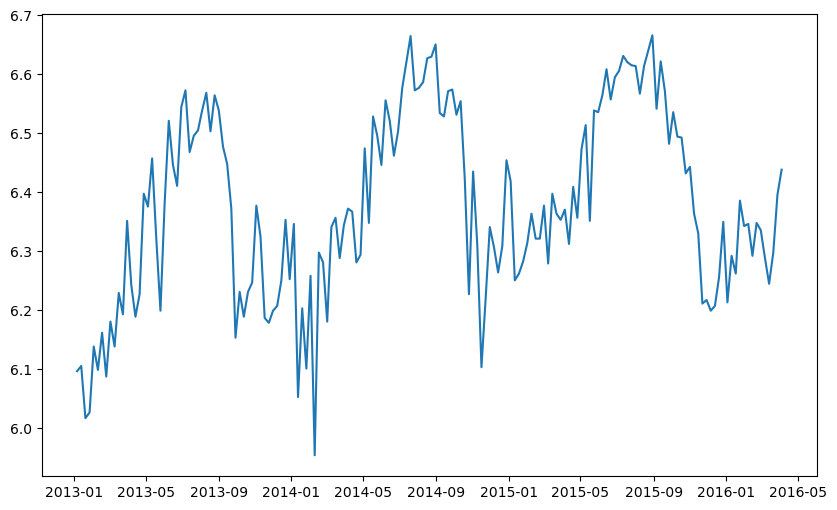

In [14]:
ts_log = np.log(ts)
plt.plot(ts_log)

# Moving Average

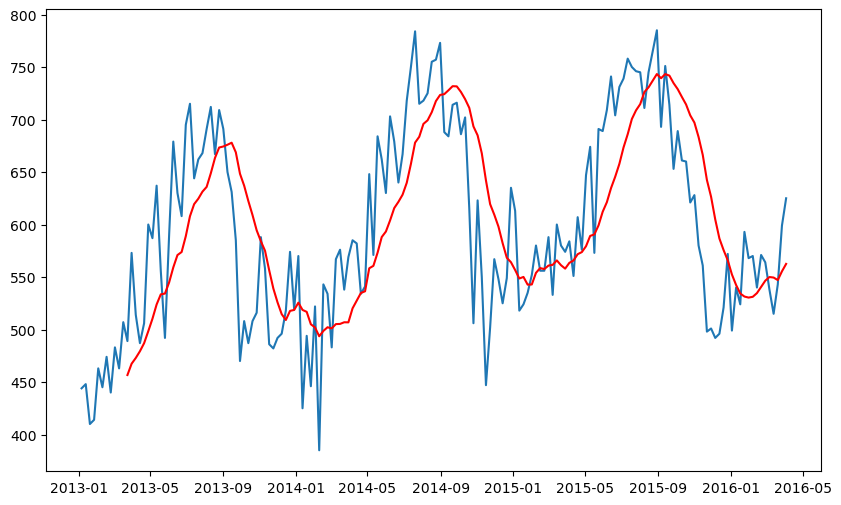

In [15]:
moving_avg = ts.rolling(window=12, center=False).mean()
plt.plot(ts)
plt.plot(moving_avg, color="red")

# First Differencing Order

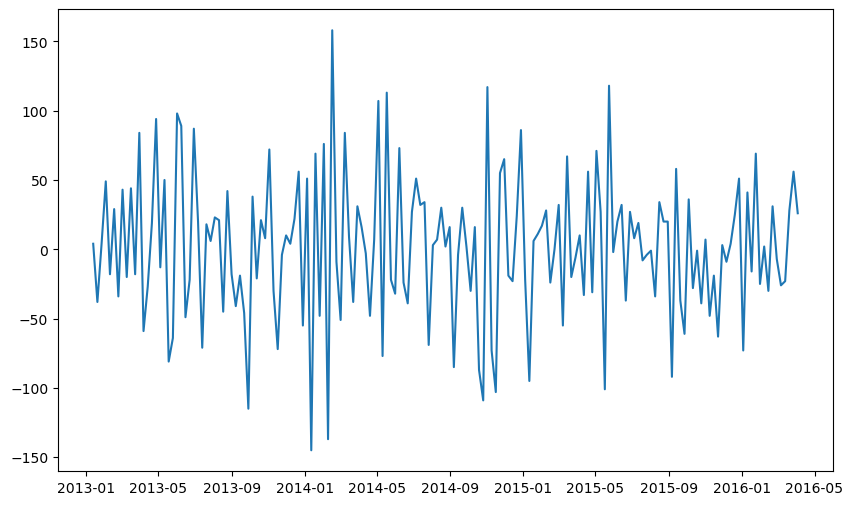

In [16]:
ts_diff = ts - ts.shift()
plt.plot(ts_diff)

# First order differencing

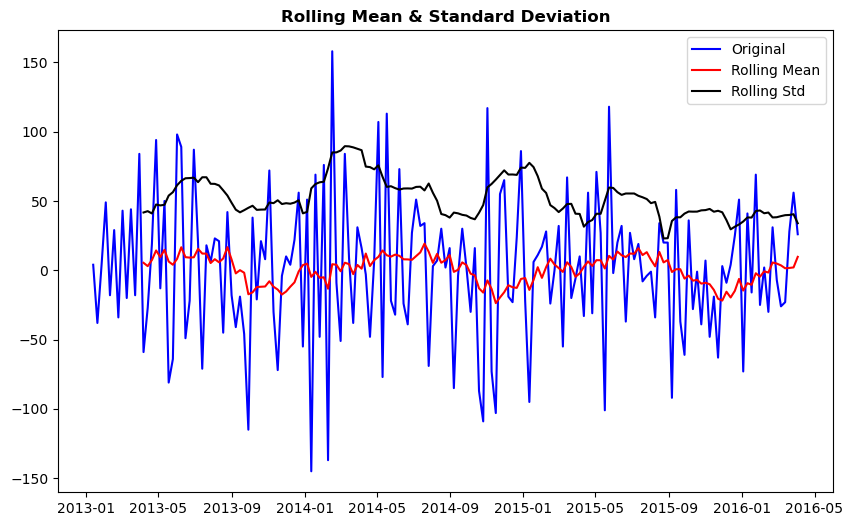

Results of Dickey-Fuller Test:
Test Statistic                -1.260532e+01
p-value                        1.700866e-23
#Lags Used                     1.000000e+00
Number of Observations Used    1.670000e+02
Critical Value (1%)           -3.470126e+00
Critical Value (5%)           -2.879008e+00
Critical Value (10%)          -2.576083e+00
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [17]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

# Second Order Differencing

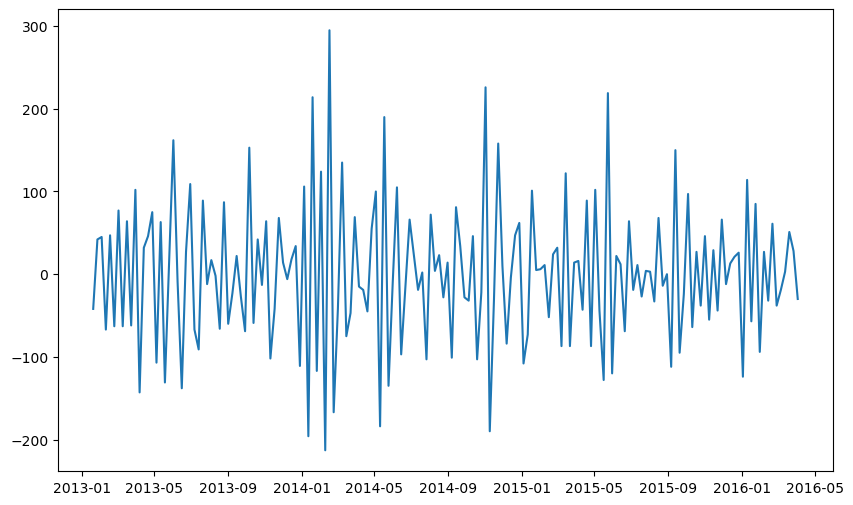

In [18]:
ts_diff2 = ts - ts.shift() - (ts.shift() - ts.shift(2))
plt.plot(ts_diff2)

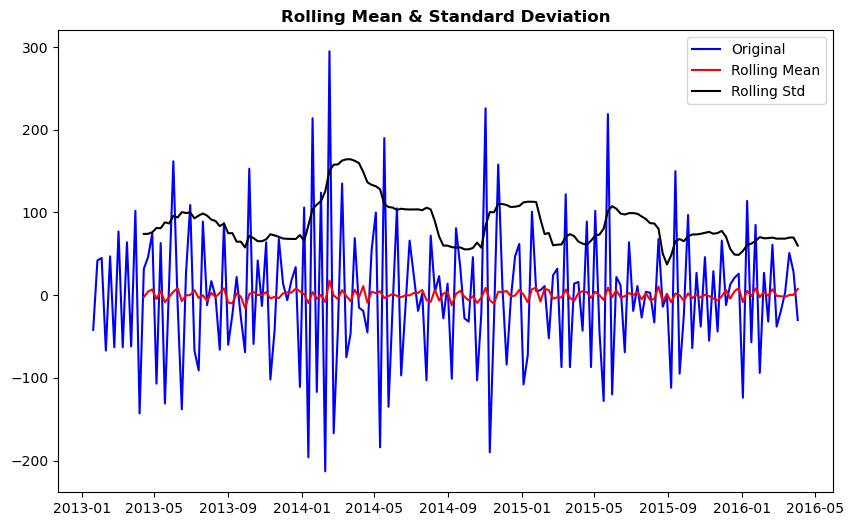

Results of Dickey-Fuller Test:
Test Statistic                -7.790139e+00
p-value                        7.982489e-12
#Lags Used                     8.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [19]:
ts_diff2.dropna(inplace=True)
test_stationarity(ts_diff2)

# Forecasting using ACF and PACF

In [20]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

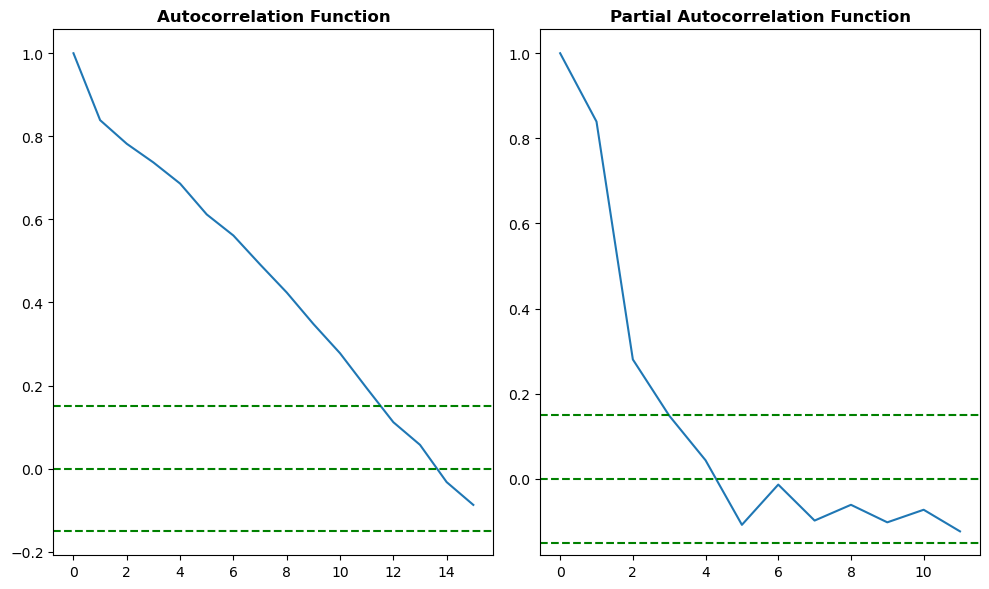

In [21]:
lag_acf = acf(ts, nlags=15)
lag_pacf = pacf(ts, nlags=11, method="ols")

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle="--", color="green")
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="green")
plt.axhline(y=1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="green")
plt.title("Autocorrelation Function")

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle="--", color="green")
plt.axhline(y=-1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="green")
plt.axhline(y=1.96 / np.sqrt(len(ts_diff2)), linestyle="--", color="green")
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

# AR Model

In [22]:
from statsmodels.tsa.arima.model import ARIMA

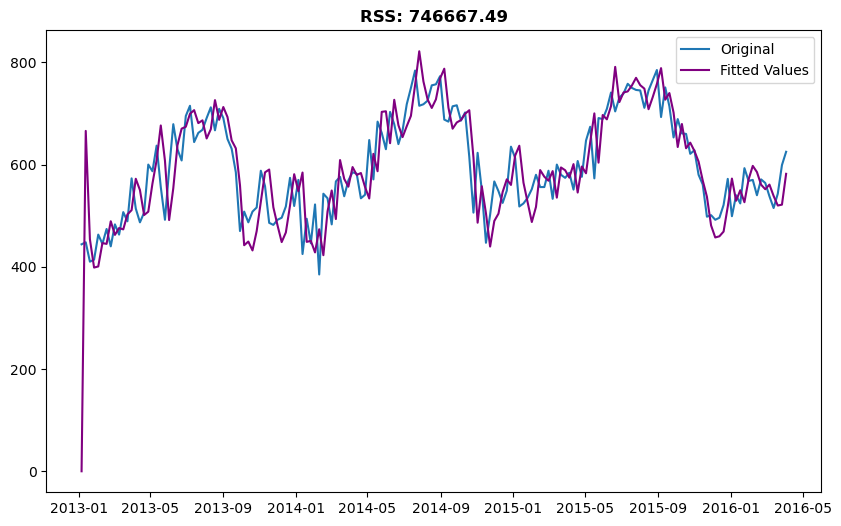

In [23]:
model = ARIMA(ts, order=(3, 2, 0))
results_AR = model.fit()
plt.plot(ts, label="Original")
plt.plot(results_AR.fittedvalues, color="purple", label="Fitted Values")
plt.title("RSS: %.2f" % sum((results_AR.fittedvalues - ts) ** 2))
plt.legend(loc="best")
plt.show()

# MA Model

Text(0.5, 1.0, 'RSS: 631083.31')

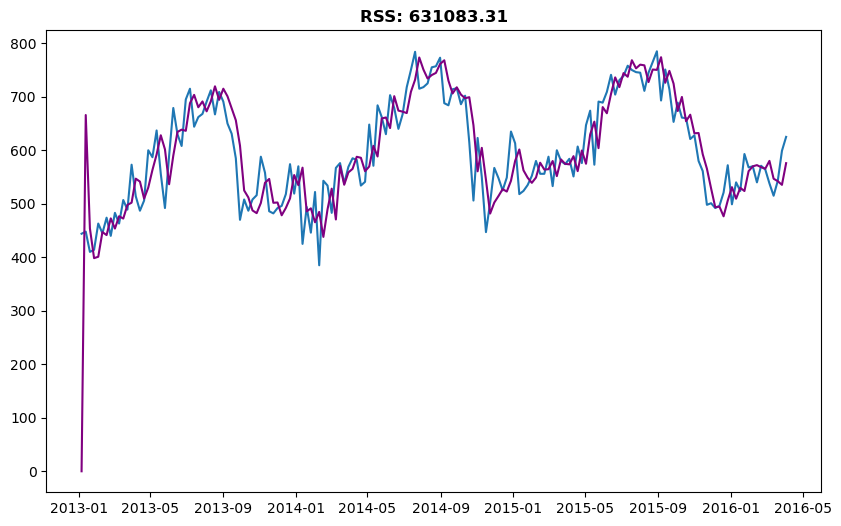

In [24]:
model = ARIMA(ts, order=(0, 2, 11))
results_MA = model.fit()
plt.plot(ts)
plt.plot(results_MA.fittedvalues, color="purple")
plt.title("RSS: %.2f" % sum((results_MA.fittedvalues - ts) ** 2))

# Combined Model

C:\Users\KAMAU\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'RSS: 625430.89')

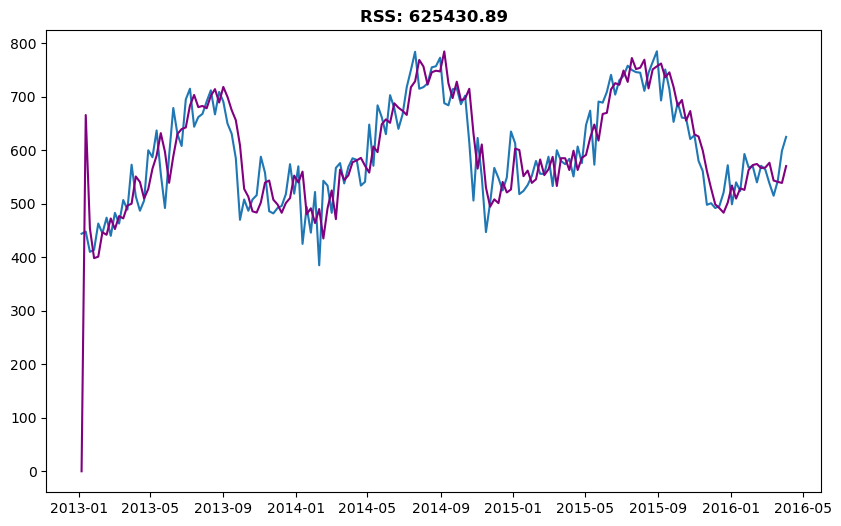

In [25]:
model = ARIMA(ts, order=(3, 2, 11))
results_ARIMA = model.fit()
plt.plot(ts)
plt.plot(results_ARIMA.fittedvalues, color="purple")
plt.title("RSS: %.2f" % sum((results_ARIMA.fittedvalues - ts) ** 2))

# Multi-Step Forecasting

In [26]:
yhat_val = results_ARIMA.forecast(steps=26)
yhat_test = results_ARIMA.forecast(steps=3)[-13:]

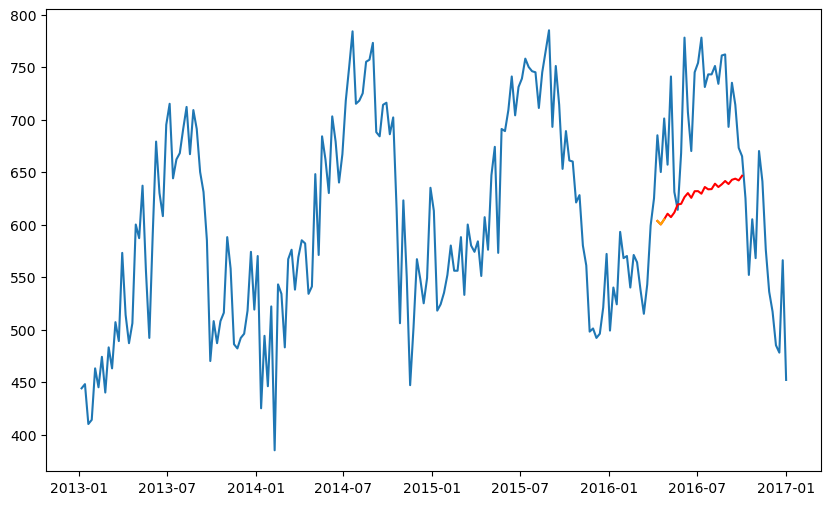

In [27]:
plt.plot(street_crimes)
plt.plot(yhat_val, color="red")
plt.plot(yhat_test, color="orange")

# Mean Absolute Percentage Error

In [28]:
# Avoid division by zero, replace 0 values with a small number
ts_no_zeros = ts.replace(0, 1e-10)

mape = np.mean(np.abs((ts - results_AR.fittedvalues) / ts_no_zeros)) * 100

# Print the MAPE
print("Mean Absolute Percentage Error (MAPE): %.2f%%" % mape)

Mean Absolute Percentage Error (MAPE): 8.44%


# Clustering

In [30]:
from sklearn.preprocessing import LabelEncoder

# Initializing LabelEncoder
label_encoder = LabelEncoder()

# Applying LabelEncoder to 'CATEGORY' and 'CALL GROUPS'
df['CATEGORY'] = label_encoder.fit_transform(df['CATEGORY'])
df['CALL GROUPS'] = label_encoder.fit_transform(df['CALL GROUPS'])

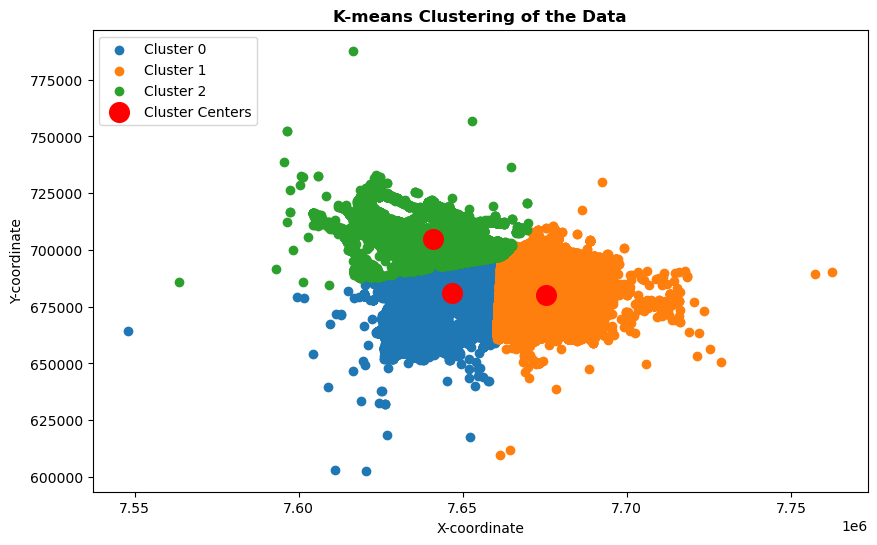

In [31]:
from sklearn.cluster import KMeans

# Using 'x_coordinate' and 'y_coordinate' as the features for clustering
features = df[['x_coordinate', 'y_coordinate']]

# Number of clusters 
num_clusters = 3

# Fit K-means clustering model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Target'] = kmeans.fit_predict(features)

# Visualize the clusters
for cluster_id in range(num_clusters):
    cluster_data = df[df['Target'] == cluster_id]
    plt.scatter(cluster_data['x_coordinate'], cluster_data['y_coordinate'], label=f'Cluster {cluster_id}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='o', label='Cluster Centers')
plt.title('K-means Clustering of the Data')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()